In [37]:
from astropy.table import Table
from astropy.io import fits
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from minisom import MiniSom
import pickle

In [21]:
df_L3_info = Table.read('../dataset/L3_COSMOS2020_Richard_RefCat_2023DEC4_info.fits')
df_L3_info = df_L3_info.to_pandas()

In [22]:
L3_phot_data = np.loadtxt('../dataset/L3_COSMOS2020_Richard_RefCat_2023DEC4_averaged_phot102.txt')
phot_data = L3_phot_data[:,3::2]
phot_err_data = L3_phot_data[:,4::2]

In [ ]:
plt.hist(df_L3_info["z_true"], bins = 20)
plt.show()

In [ ]:
plt.hist(df_L3_info["HSC_i_MAG"], bins = 40)
plt.show()

In [66]:
def remove_low_SNR(data, data_err, info_data, mode, mag_cut):
    i_band = info_data["HSC_i_MAG"].values
    if mode == "mag_cut":
        if type(mag_cut) == type(1):
            max_cut = np.mean(i_band) - np.std(i_band, ddof = 1) * mag_out
            data = data[i_band < max_cut]
            data_err = data[i_band < max_cut]
            return data, data_err
        else:
            data = data[(i_band < mag_cut[1]) & (i_band > mag_cut[0])]
            data_err = data[(i_band < mag_cut[1]) & (i_band > mag_cut[0])]
            return data, data_err
    elif mode == "band_cut":
        data = data[:, : len(data[0]) - 34]
        data_err = data_err[:, : len(data_err[0]) - 34]
        return data, data_err

In [67]:
data, data_err = remove_low_SNR(data = phot_data, data_err = phot_err_data, info_data = df_L3_info , mode = "band_cut", mag_cut = None)

In [ ]:
plt.plot(dq
         ta_err)

In [33]:
def preprocess(data, data_err, mode):
    if mode == "default":
        proc_data = (data - np.mean(data, axis=0)) / np.std(data, ddof = 1, axis=0)
        return proc_data
    elif mode == "SNR":
        proc_data = data / data_err
        proc_data = (proc_data - np.mean(proc_data, axis=0)) / np.std(proc_data, ddof = 1, axis=0)
        return proc_data

In [34]:
def basic_som(data, dim, cmap, iteration = 1, sigma = 1, learning_rate = 1):
    som = MiniSom(dim, dim, data.shape[1], sigma = sigma, learning_rate = learning_rate)
    som.random_weights_init(data)
    som.train(data, iteration, use_epochs = True)

    print("Finish traininging SOM.")
    print("Start making diagrams...")

    density_map = np.zeros(dim ** 2).reshape(dim, dim)
    magnitude_map = np.zeros(dim ** 2).reshape(dim, dim)
    magnitude_map.fill(np.nan)
    z_map = np.zeros(dim ** 2).reshape(dim, dim)
    z_map.fill(np.nan)
    
    labels_map_1 = som.labels_map(data, [0] * len(data))
    labels_map_2 = som.labels_map(data, tuple(map(tuple, np.concatenate((np.expand_dims(df_L3_info["HSC_i_MAG"].values, axis = 1), np.expand_dims(df_L3_info["z_true"].values, axis = 1)), axis = -1))))

    for i in labels_map_1.keys():
        density_map[int(list(i)[0]), int(list(i)[1])] = labels_map_1[i][0]

    print("Finish collecting data for density map.")
    
    for i in labels_map_2.keys():
        properties = np.mean(np.array(list(labels_map_2[i].keys())), axis = 0)
        magnitude_map[int(list(i)[0]), int(list(i)[1])] = properties[0]
        z_map[int(list(i)[0]), int(list(i)[1])] = properties[1]

    print("Finish collecting data for magnitude map.")

    print(f"Topological error: {som.topographic_error(data)}")
    print(f"Quantization error: {som.quantization_error(data)}")

    %matplotlib inline
    plt.close()
    plt.figure(figsize = (25, 25))
    plt.subplot(221)
    plt.pcolor(som.distance_map().T, cmap='YlGn')  # plotting the distance map as background
    plt.colorbar()
    plt.title("Distance map (U-matrix)")

    plt.subplot(222)
    plt.pcolor(density_map.T, cmap='YlGn')
    plt.colorbar()
    plt.title("Density Map")

    plt.subplot(223)
    plt.pcolor(magnitude_map.T, cmap="plasma" + "_r")
    plt.colorbar()
    plt.title("HSC I Magnitude Map")

    plt.subplot(224)
    plt.pcolor(z_map.T, cmap="jet")
    plt.colorbar()
    plt.title("True Redshift Map")
    
    return som

In [35]:
proc_data = preprocess(data = phot_data, data_err = phot_err_data, mode = "SNR")

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\minisom.py:540: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


Topological error: 0.9811689405423615
Quantization error: 6.356420403211315


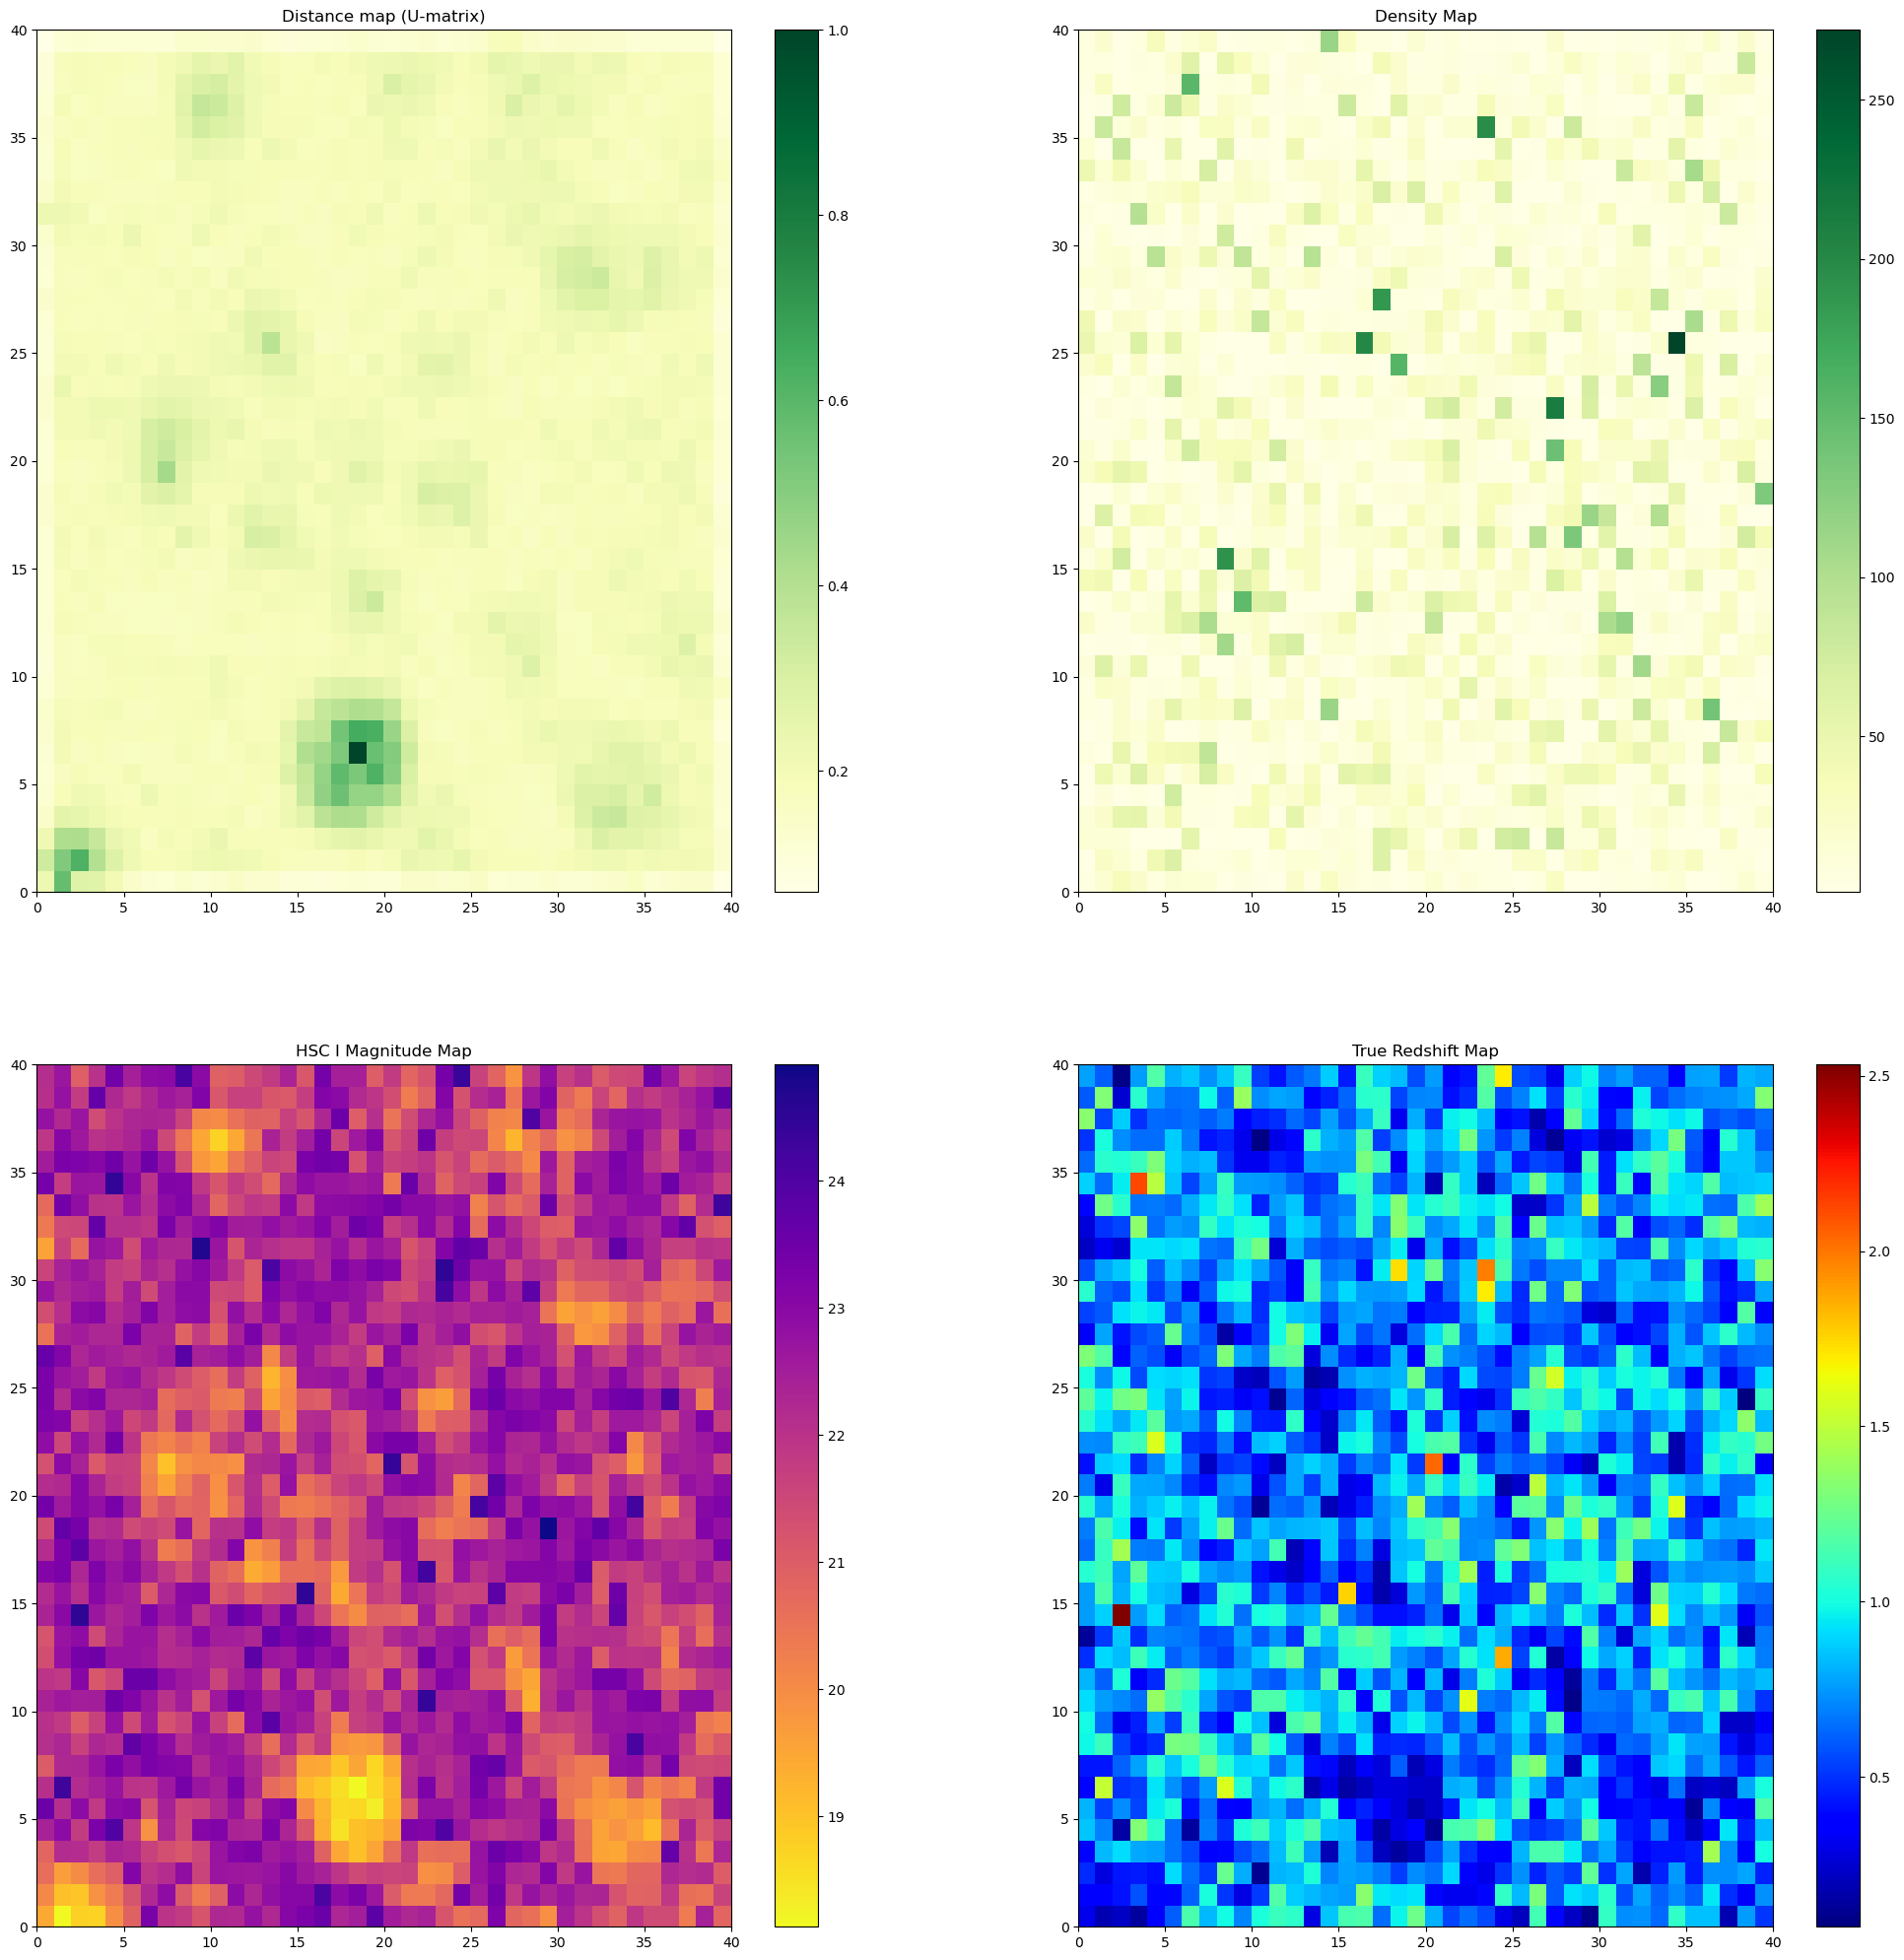

In [36]:
som = basic_som(data = proc_data, dim = 40, cmap = "viridis", sigma = 0.4)

In [ ]:
# som = MiniSom(100, 100, data.shape[1], sigma=  1, learning_rate = 1,
#               neighborhood_function='gaussian', random_seed=10)

# max_iter = 1000
# q_error = []
# t_error = []

# for i in range(max_iter):
#     rand_i = np.random.randint(len(data))
#     som.update(data[rand_i], som.winner(data[rand_i]), i, max_iter)
#     q_error.append(som.quantization_error(data))
#     t_error.append(som.topographic_error(data))

# plt.plot(np.arange(max_iter), q_error, label='quantization error')
# plt.plot(np.arange(max_iter), t_error, label='topographic error')
# plt.ylabel('error')
# plt.xlabel('iteration index')
# plt.legend()
# plt.show()